![title](https://image.ibb.co/erDntK/logo2018.png)

---




# Task 12 part 3/3 - Train CIFAR10 using TPU

In this last part of assignment you will try to train a five layer CNN on CIFAR-10 dataset using free 8 TPUs provided by google

The goals of this assignment are as follows:

<pre>* train a five layer CNN using TPU</pre>

---
<font size=4 color="blue">Note: 
  <br>Before running this file, <br>Close all other Google Colaboratory tabs that are still active<br>
as it may hinder the TPU processing
  
---

---
---
#[Part 0] Import Libraries and Load Data

---
## 0 - Acceleration Setting

This time we will check the ability of TensorFlow if it is run with TPU acceleration.

For that, make sure that this Google Colab use **TPU** Runtime acceleration.
* Select the Runtime menu
* Change Runtime Type
* Choose **TPU**

<img src = "https://i.ibb.co/6t5CCyL/tpu.png" align = "center">



---
## 1 - Install TensorFlow 2 ?

We'd love to use TensorFlow 2 for this exercise as well

But unfortunately, up to the time this exercise is published, the TPU support for Keras API is not yet completed, and still under development

So we're back using Tensorflow 1.15 

:(

In [0]:
# !pip install tensorflow-gpu -q

In [0]:
import tensorflow as tf
tf.__version__

'1.15.0'

**EXPECTED OUTPUT**:
<pre>
 '1.15.0'

In [0]:
import torch
torch.__version__

'1.3.0+cu100'

**EXPECTED OUTPUT**:
<pre>
 '1.3.0'

---
## 2 - Import Libraries
Import required libraries

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import pprint

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

%matplotlib inline
np.set_printoptions(precision=7)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Write down your Name and Student ID

In [0]:
## --- start your code here ----

NIM = 1301160098
Nama = "Panji Bagaskara"

## --- end your code here ----

---
## 3 - Load CIFAR-10

In [0]:
(X_train_ori, y_train), (X_test_ori, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---
## 4 - Split Validation Data

In [0]:
X_val_ori = X_train_ori[-10000:,:]
y_val     = y_train[-10000:]

X_train_ori = X_train_ori[:-10000, :]
y_train     = y_train[:-10000]

---
## 5 - Normalize and Reshape Data

In [0]:
X_train = X_train_ori.astype('float32')
X_val   = X_val_ori.astype('float32')
X_test  = X_test_ori.astype('float32')

mean_image = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_image = X_train.std(axis=(0, 1, 2), keepdims=True)

X_train = (X_train - mean_image) /std_image
X_val = (X_val - mean_image) /std_image
X_test = (X_test - mean_image) /std_image

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('\ny_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (40000, 32, 32, 3)
X_val.shape   = (10000, 32, 32, 3)
X_test.shape  = (10000, 32, 32, 3)

y_train.shape = (40000,)
y_val.shape   = (10000,)
y_test.shape  = (10000,)


one hot the label

In [0]:
y_train_hot = to_categorical(y_train, 10)
y_val_hot   = to_categorical(y_val, 10)
y_test_hot  = to_categorical(y_test, 10)

print('y_train_hot.shape =',y_train_hot.shape)
print('y_val_hot.shape   =',y_val_hot.shape)
print('y_test_hot.shape  =',y_test_hot.shape)

y_train_hot.shape = (40000, 10)
y_val_hot.shape   = (10000, 10)
y_test_hot.shape  = (10000, 10)


---
## 6 - Helper Function

In [0]:
def plot_history(history):
  plt.rcParams['figure.figsize'] = [12, 4]
  plt.subplots_adjust(wspace=0.2)

  plt.subplot(121)
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'])

  plt.subplot(122)
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'])
  plt.show()

---
---
# [Part 1] Device Acceleration Checking

## 1 - GPU Availability Check

Next, let's check TensorFlow and PyTorch's ability to utilize GPU capabilities

**Because we set this Google Colab to with TPU acceleration, there will be no GPU name displayed**

In [0]:
print('Using GPU:', tf.test.is_gpu_available())

if tf.test.is_gpu_available():
  print('GPU name :', tf.test.gpu_device_name())


Using GPU: False


**EXPECTED OUTPUT**:
<pre>
    Using GPU: False

In [0]:
print('Using GPU:',torch.cuda.is_available())

if torch.cuda.is_available():
  print('GPU name :',torch.cuda.get_device_name(0))


Using GPU: False


**EXPECTED OUTPUT**:
<pre>
    Using GPU: False

## 2 - TPU Availability Check

Then, let's check TensorFlow's ability to utilize TPU capabilities 

**Because we set this Google Colab to run with TPU acceleration, it will show that Google provided us with 8 Free TPUs**

In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to a TPU runtime')
  
else:
  
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  # for tf 2.x
  # tf.config.experimental_connect_to_host(tpu_address)
  # devices=tf.config.experimental_list_devices()
  
  # for tf 1.x  
  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:') 
  print(*devices, sep="\n")

TPU address is grpc://10.58.106.66:8470
TPU devices:
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 11320270380297339401)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12818627154017957925)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6678056319386634630)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10156652759600296857)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 18076727761523152582)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 18027516433911032826)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8593328530837418655)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12182749458717923945)
_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 6256487123614141099)
_Devic

**EXPECTED OUTPUT**:
<pre>
    TPU address is grpc://10.xxx.xxx.xxx:xxxx
    TPU devices: 
     /job:tpu_worker/replica:0/task:0/device:CPU:0
     /job:tpu_worker/replica:0/task:0/device:XLA_CPU:0
     /job:tpu_worker/replica:0/task:0/device:TPU:0
               ... **you should see 8 TPU devices from id device:TPU:0 to 7** ...
     /job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0

---
---
# [Part 2] Train 5-layer ConvNet

Now let's build and train our model



In [0]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D


---
## 1 - Model Builder

#### <font color='red'>**EXERCISE**: </font>
**Define a ConvNet Model as follow**

    * 32 @ Conv 3x3 using relu and padding same
    * 32 @ Conv 3x3 using relu and padding same
    * Max Pool
    * 64 @ Conv 3x3 using relu and padding same    
    * Max Pool
    * Flatten
    * Dense 200 using relu
    * Dense 10 using softmax
    
    then compile using categorical crossentropy and optimizer adam


In [0]:
# for tf 1.x
def FiveConvNet(name):
  
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)
  
  print('\n\n-----------------------------------------------------')
  
  with strategy.scope():
    
    model = Sequential([

        Conv2D(32, (3,3), padding='SAME', activation='relu', input_shape=(32,32,3)), # conv
        Conv2D(32, (3,3), padding='SAME', activation='relu'), # conv
        MaxPool2D(), # pool
        Conv2D(64, (3,3), padding='SAME', activation='relu'), # conv
        MaxPool2D(), # pool
        Flatten(), # flatten
        Dense(200, activation='relu'), # dense
        Dense(10, activation='softmax')  # dense

    ], name = name) 
    
    model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])
  
  return model

---
## 2 - Define Model

In [30]:
model = FiveConvNet('using_TPU')

model.summary()

INFO:tensorflow:Initializing the TPU system: 10.58.106.66:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.58.106.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11320270380297339401)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6678056319386634630)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10156652759600296857)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 18076727761523152582)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/dev

**EXPECTED OUTPUT**:
<pre>
Model: "using_TPU"
conv2d (Conv2D)              (None, 32, 32, 32)        896       
...
dense_? (Dense)              (None, 10)                2010        

Total params: 850,050
Trainable params: 850,050
Non-trainable params: 0
_________________________________________________________________

---
## 3 - Train Model



#### <font color='red'>**EXERCISE**: </font>
**Train the model for 8 epochs using batch size 200**

**Don't forget to feed the validation data**


    

In [31]:
import time

num_epochs = 8
batch_size = 200

tic = time.time()

history = model.fit(X_train, y_train_hot, 
                    validation_data=(X_val, y_val_hot),
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    verbose=2)

toc = time.time()

print('\n\ntraining speed = %.2f seconds' % (toc-tic))
print('training speed = %.2f minutes' % ((toc-tic)/60))

Epoch 1/8
INFO:tensorflow:Running validation at fit epoch: 0
50/50 [==============================] - 3s 63ms/step
200/200 - 8s - loss: 1.4733 - acc: 0.4782 - val_loss: 1.2344 - val_acc: 0.5692
Epoch 2/8
INFO:tensorflow:Running validation at fit epoch: 1
50/50 [==============================] - 3s 66ms/step
200/200 - 7s - loss: 1.0377 - acc: 0.6393 - val_loss: 1.0152 - val_acc: 0.6428
Epoch 3/8
INFO:tensorflow:Running validation at fit epoch: 2
50/50 [==============================] - 4s 74ms/step
200/200 - 7s - loss: 0.8419 - acc: 0.7059 - val_loss: 0.8969 - val_acc: 0.6877
Epoch 4/8
INFO:tensorflow:Running validation at fit epoch: 3
50/50 [==============================] - 4s 82ms/step
200/200 - 8s - loss: 0.7255 - acc: 0.7476 - val_loss: 0.8496 - val_acc: 0.7072
Epoch 5/8
INFO:tensorflow:Running validation at fit epoch: 4
50/50 [==============================] - 4s 87ms/step
200/200 - 8s - loss: 0.6095 - acc: 0.7869 - val_loss: 0.8271 - val_acc: 0.7175
Epoch 6/8
INFO:tensorflow:Runn

**EXPECTED OUTPUT**:
<pre>
Your model should run in about 8 seconds per epoch
it's slower than using GPU
and somehow the speed is decreasing along the epoch

This happened because the TPU is not yet effectively implemented for Keras API

---
## 4 - Visualize Training

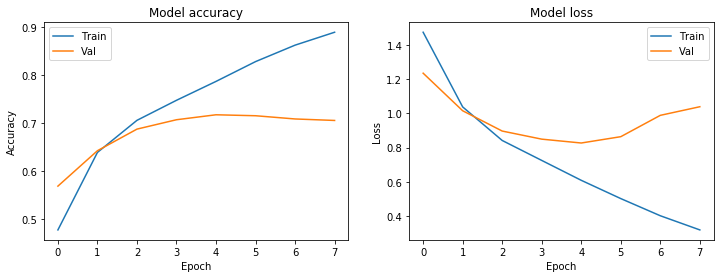

In [32]:
plot_history(history)

---
## 5 - Evaluate Model

In [33]:
val_scores   = model.evaluate(X_val, y_val_hot, verbose=2)
test_scores  = model.evaluate(X_test, y_test_hot, verbose=2)

313/313 [==============================] - 8s 26ms/step


In [34]:
print('val  acc %.2f%%' % (val_scores[1]*100))
print('test acc %.2f%%' % (test_scores[1]*100))

val  acc 70.57%
test acc 70.18%


**EXPECTED OUTPUT**:
<pre>
You should get around 70% accuracy on data test
tough the model is overfit

---
---
# [Part 3] Train VGG16

To clearly compare the TPU performance in speeding up the computation, let's use the VGG16 to train CIFAR10 dataset

---
## 1 - Model Builder

#### <font color='red'>**EXERCISE**: </font>
**Define a ConvNet Model as follow**

    * vgg16 model with weights=None, include_top=False, and input_shape=(32,32,3)
    * get layer 'block4_conv3' output
    * GlobalAveragePooling2D
    * Dense 200 using relu
    * Dense 10 using softmax
    
    use Functional API,
    then compile using categorical crossentropy and optimizer adam


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

def CifarVGG(name):
  
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)
  
  with strategy.scope():
    
    # load empty vgg16 no top with input (32,32,3)
    model = VGG16(include_top=False, weights=None, input_shape=(32,32,3))

    # get 'block4_conv3' output using model.get_layer()
    x = model.get_layer('block4_conv3').output

    # global average pooling
    x = GlobalAveragePooling2D()(x)

    # dense 200
    x = Dense(200, activation='relu')(x)

    # dense 10
    prediction = Dense(10, activation='softmax')(x)

    # instantiate model
    myModel = Model(inputs=model.input, outputs=prediction, name=name)
    
    myModel.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])
  
  return myModel
  

---
## 2 - Define Model

In [36]:
model = CifarVGG('VGG_using_TPU')

model.summary()

INFO:tensorflow:Initializing the TPU system: 10.58.106.66:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.58.106.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11320270380297339401)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6678056319386634630)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 10156652759600296857)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 18076727761523152582)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/dev

**EXPECTED OUTPUT**:
<pre>
Model: "VGG_using_TPU"
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
...
dense_? (Dense)              (None, 200)               102600    
prediction (Dense)           (None, 10)                2010      

Total params: 7,739,874
Trainable params: 7,739,874
Non-trainable params: 0
_________________________________________________________________

---
## 3 - Train Model

Now let's train it for 10 epoch and greater batch size of 1000

Notice that we're not using validation data

TPU acceleration using Keras API, at the moment, is still experimental. And passing validation data in `.fit()` function slows down the process considerably

In [37]:
import time

num_epochs = 10
batch_size = 1000

tic = time.time()

history = model.fit(X_train, y_train_hot, 
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    verbose=2)

toc = time.time()

print('\n\ntraining speed = %.2f seconds' % (toc-tic))
print('training speed = %.2f minutes' % ((toc-tic)/60))

Epoch 1/10
40/40 - 7s - loss: 2.2569 - acc: 0.1244
Epoch 2/10
40/40 - 4s - loss: 1.9545 - acc: 0.2461
Epoch 3/10
40/40 - 4s - loss: 1.7196 - acc: 0.3440
Epoch 4/10
40/40 - 4s - loss: 1.5277 - acc: 0.4227
Epoch 5/10
40/40 - 4s - loss: 1.3555 - acc: 0.4935
Epoch 6/10
40/40 - 4s - loss: 1.1827 - acc: 0.5696
Epoch 7/10
40/40 - 4s - loss: 1.0391 - acc: 0.6244
Epoch 8/10
40/40 - 4s - loss: 0.9071 - acc: 0.6751
Epoch 9/10
40/40 - 4s - loss: 0.7804 - acc: 0.7237
Epoch 10/10
40/40 - 4s - loss: 0.6655 - acc: 0.7644


training speed = 81.13 seconds
training speed = 1.35 minutes


**EXPECTED OUTPUT**:
<pre>
Your model should run in about 5 seconds per epoch

about 4x faster than using GPU

---
## 4 - Evaluate Model

In [38]:
val_scores   = model.evaluate(X_val, y_val_hot, verbose=2)
test_scores  = model.evaluate(X_test, y_test_hot, verbose=2)

313/313 [==============================] - 15s 48ms/step


In [39]:
print('val  acc %.2f%%' % (val_scores[1]*100))
print('test acc %.2f%%' % (test_scores[1]*100))

val  acc 73.46%
test acc 72.84%


**EXPECTED OUTPUT**:
<pre>
You should get around 70% accuracy on data test



---

# Congratulation, You've Completed Exercise 12 part 3/3

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2019 - ADF</a> </p>

![footer](https://image.ibb.co/hAHDYK/footer2018.png)